# Problem 5

- Please train UNet2DModel using MNIST (hand written digits) without conditioning.
- Report the loss curve.
- Test the trained model by sampling 2 times 4 new digits.

In [2]:
!pip install datasets
!pip install torch
!pip install nbdev
!pip install genaibook
!pip install transformers
!pip install torchvision
!pip install diffusers
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.1/66.1 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 2.7 MB/s eta 0:00:00


In [4]:
import torch

print(torch.__version__)
print("GPU Available:", torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"

print(f"Using device type: {device}")

2.1.0+cu121
GPU Available: True
Using device type: cuda:0


In [5]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [6]:
from datasets import load_dataset

dataset = load_dataset("mnist", split="train")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [7]:
from torchvision import transforms

image_size = 64

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


In [8]:
import torch
batch_size = 16


def transform(examples):
    examples = [preprocess(image) for image in examples["image"]]
    return {"images": examples}


dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)


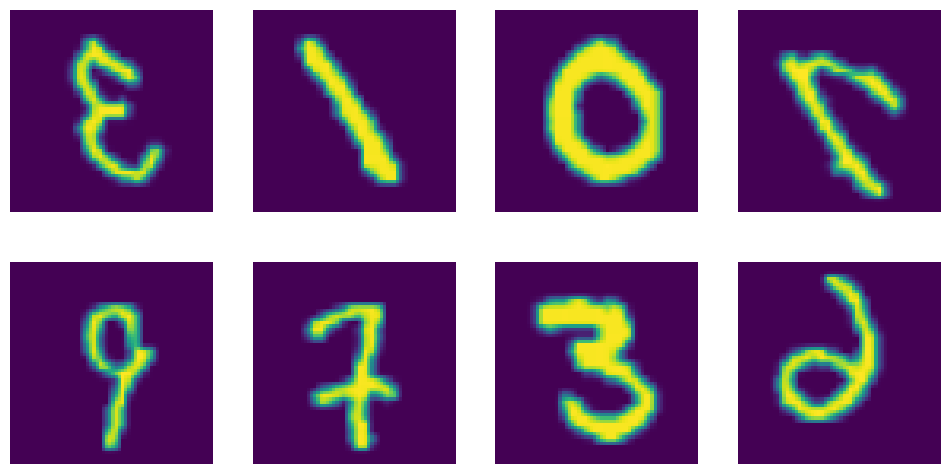

In [9]:
from genaibook.core import show_images

batch = next(iter(train_dataloader))

# We map back to (0, 1) for display
show_images(batch["images"][:8] * 0.5 + 0.5)

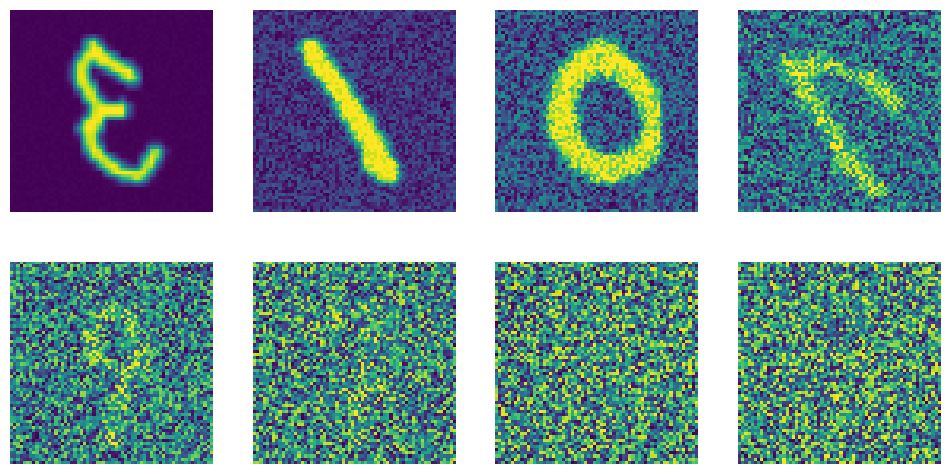

In [10]:
from diffusers import DDPMScheduler

# We'll learn about beta_start and beta_end in the next sections
scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_start=0.001, beta_end=0.02
)
timesteps = torch.linspace(0, 999, 8).long()

# We load 8 images from the dataset and
# add increasing amounts of noise to them
x = batch["images"][:8]
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)
show_images((noised_x * 0.5 + 0.5).clip(0, 1))


In [11]:
from diffusers import UNet2DModel

# Create a UNet2DModel
model = UNet2DModel(
    in_channels=1,  # 1 channel for MNIST images
    sample_size=64,  # Specify our input size
    # The number of channels per block affects the model size
    block_out_channels=(64, 128, 256, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
        ),
    out_channels=1,
    up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
).to(device)

# Pass a batch of data through to see it works
with torch.no_grad():
    out = model(noised_x.to(device), timestep=timesteps.to(device)).sample

out.shape

torch.Size([8, 1, 64, 64])

In [36]:
from torch.nn import functional as F

num_epochs = 4  # Decreasing epochs to overcome colab runtime disconnect issue
lr = 1e-4  # What learning rate should we use
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
losses = []  # Somewhere to store the loss values for later plotting

# Train the model (this takes a while!)
for epoch in range(num_epochs):
    for batch in train_dataloader:
        # Load the input images
        clean_images = batch["images"].to(device)

        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(device)

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0,
            scheduler.config.num_train_timesteps,
            (clean_images.shape[0],),
            device=device,
        ).long()

        # Add noise to the clean images according
        # to the noise magnitude at each timestep
        noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction for the noise
        # The model also uses the timestep as an input
        # for additional conditioning
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Compare the prediction with the actual noise
        loss = F.mse_loss(noise_pred, noise)

        # Store the loss for later plotting
        losses.append(loss.item())

        # Update the model parameters with the optimizer based on this loss
        loss.backward(loss)
        optimizer.step()
        optimizer.zero_grad()

    print("epoch", epoch)
    print("loss", loss)


epoch 0
loss tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch 1
loss tensor(0.0056, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch 2
loss tensor(0.0069, device='cuda:0', grad_fn=<MseLossBackward0>)
epoch 3
loss tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward0>)


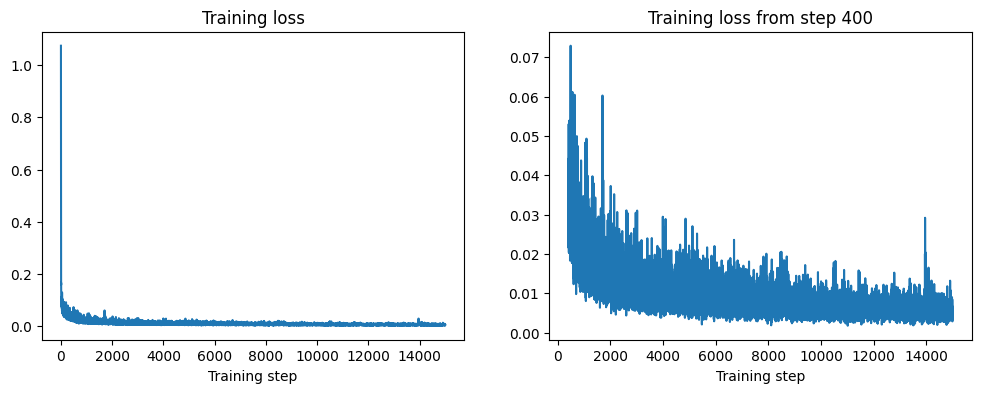

In [37]:
from matplotlib import pyplot as plt

plt.subplots(1, 2, figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Training loss")
plt.xlabel("Training step")

plt.subplot(1, 2, 2)
plt.plot(range(400, len(losses)), losses[400:])
plt.title("Training loss from step 400")
plt.xlabel("Training step");

## At this point I again was disconnected from colab.  As I had already used the majority of my available GPU credits on this assignment attempting to run the full training for the Unet model, I am executing the code below on output from an untrained Unet model.  

  0%|          | 0/1000 [00:00<?, ?it/s]

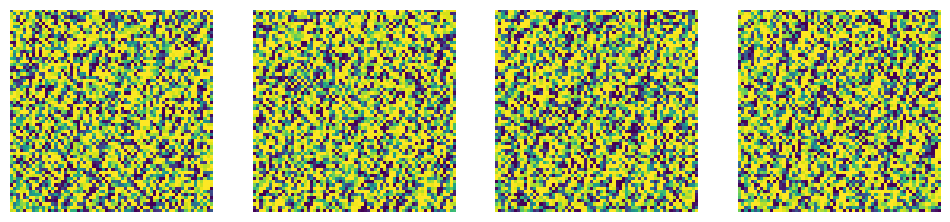

In [13]:
from diffusers import DDPMPipeline

pipeline = DDPMPipeline(unet=model, scheduler=scheduler)
ims = pipeline(batch_size=4).images
show_images(ims, nrows=1)

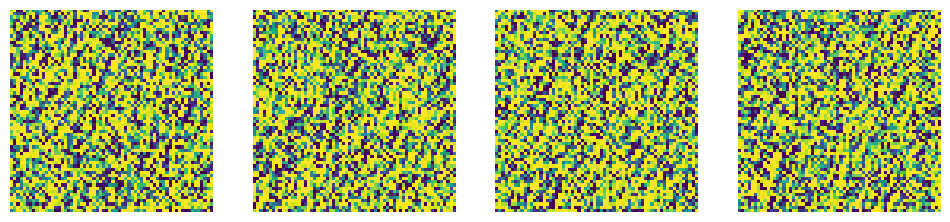

In [15]:
# Random starting point (4 random images):
sample = torch.randn(4, 1, 64, 64).to(device)

for t in scheduler.timesteps:
    # Get the model prediction
    with torch.no_grad():
        noise_pred = model(sample, t)["sample"]

    # Update sample with step
    sample = scheduler.step(noise_pred, t, sample).prev_sample

show_images(sample.clip(-1, 1) * 0.5 + 0.5, nrows=1)
